# Imports & Downloads

In [ ]:
import torch
from torch import nn
import numpy as np

import sklearn

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn import datasets
import matplotlib.pyplot as plt

import warnings

In [ ]:
! pip install scvi-tools scanpy anndata

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.1/641.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 43.6 MB/s eta 0:00:00
 

### PCA Example (Tejas)

In [ ]:
RANDOM_SEED = 42
n, d = 1000, 50
n_components = 1
torch.manual_seed(RANDOM_SEED) # ensures reproducability of data
X = torch.randn(n, d)

true_w = torch.randn(d, n_components)

y = X @ true_w + 0.8 * torch.randn(n, 1)
y.shape

torch.Size([1000, 1])

(1000, 1)

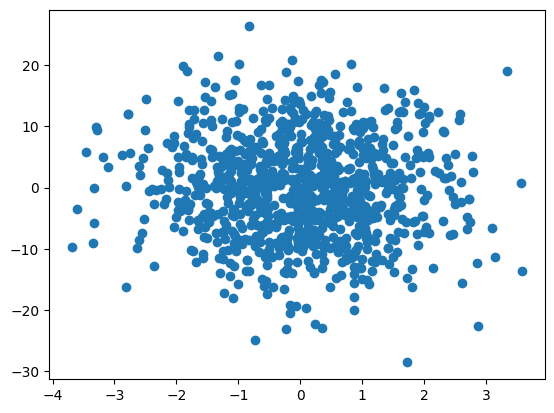

In [ ]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=1)

X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca, y)
X_pca.shape

### Simulate Data

In [ ]:
# y-label (ages) normally distributed with mean 40 and std 15
torch.manual_seed(RANDOM_SEED)
n = 1000
k = 1
p = 50 # number of input features after PCA
# generate y as ages normally distributed with mean 40 and std 15
y = torch.normal(mean=41, std=15, size=(n, 1)) # y: age data
y = torch.clamp(y, min=0, max=100)
# simulate data
true_w1 = torch.randn(k, 1)
z1 = y @ true_w1.T + 0.1 * torch.randn(n, k) # z: components extracted (n, k)
true_w2 = torch.randn(k, 1)
z2 = y @ true_w1.T + 0.1 * torch.randn(n, k)

torch.manual_seed(RANDOM_SEED)
true_w3 = torch.randn(p, k)
x1 = z1 @ true_w3.T + 0.8 * torch.randn(n, 1) # x: original input data (n, p)

true_w4 = torch.randn(p, k)
x2 = z2 @ true_w4.T + 0.8 * torch.randn(n, 1)

# print(torch.corrcoef(torch.cat([y, x2], dim=1).T))

# implement train test split
indices = range(len(y))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
x1_train, x1_test = x1[train_idx], x1[test_idx]
x2_train, x2_test = x2[train_idx], x2[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
print(torch.corrcoef(torch.cat([y_train, x2_train], dim=1).T))

tensor([[ 1.0000, -0.7943,  0.3094,  ...,  0.9972,  0.9542,  0.6284],
        [-0.7943,  1.0000,  0.3315,  ..., -0.7487, -0.5772, -0.0271],
        [ 0.3094,  0.3315,  1.0000,  ...,  0.3773,  0.5791,  0.9341],
        ...,
        [ 0.9972, -0.7487,  0.3773,  ...,  1.0000,  0.9735,  0.6830],
        [ 0.9542, -0.5772,  0.5791,  ...,  0.9735,  1.0000,  0.8319],
        [ 0.6284, -0.0271,  0.9341,  ...,  0.6830,  0.8319,  1.0000]])


In [ ]:
torch.manual_seed(RANDOM_SEED)
p = 50 # number of input features after PCA
k = 2
z = torch.normal(mean=0, std=1, size=(n, k)) # assume data is already standardized

true_w3 = torch.randn(p, k)
x1 = z @ true_w3.T + 0.8 * torch.randn(n, p) # x: original input data (n, p)

true_w4 = torch.randn(p, k)
x2 = z @ true_w4.T + 0.8 * torch.randn(n, p)

x1.shape

torch.Size([1000, 50])

### Results using default PLS in Scikit-Learn

In [ ]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=k)
pls.fit(x1_train.numpy(), y_train.numpy())

PLSRegression(n_components=1)

In [ ]:
Zx = pls.x_scores_
Zx.shape

(800, 1)

In [ ]:
import anndata as ad
import scanpy as sc

adata = ad.AnnData(X=x1_train.numpy())

adata.obsm["X_pls"] = Zx
adata.obs["age"] = y_train.numpy().flatten()

ModuleNotFoundError: No module named 'anndata'

In [ ]:
sc.pp.neighbors(adata, use_rep="X_pls")
sc.tl.umap(adata)

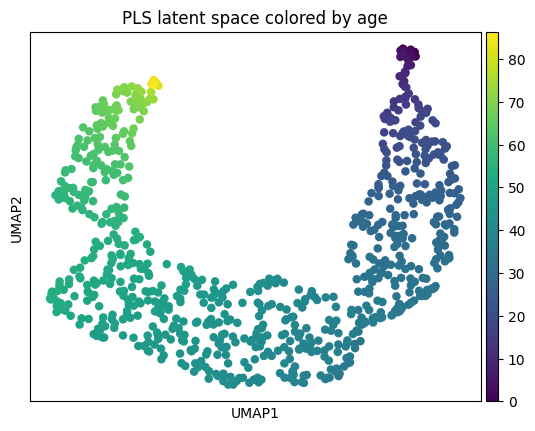

In [ ]:
sc.pl.umap(
    adata,
    color="age",
    cmap="viridis",
    title="PLS latent space colored by age"
)

### Results using torch NeuralPLS

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(RANDOM_SEED)

class NeuralPLS(nn.Module):
    def __init__(self, input_dim, n_components, output_dim=1):
        super().__init__()

        # Encoder: X -> latent PLS scores
        self.encoder_1 = nn.Linear(input_dim, n_components, bias=False)

        # Regression head: latent -> y
        self.regressor_1 = nn.Linear(n_components, output_dim, bias=False)

    def forward(self, x1, x2):
        t1 = self.encoder(x1)
        t1 = t1 - t1.mean(dim=0, keepdim=True)
        t1 = t1 / (t1.std(dim=0, keepdim=True) + 1e-8)
        y_hat = self.regressor(t1)
        return t1, y_hat

def covariance_loss(t1, y):
    t_centered = t1 - t1.mean(dim=0, keepdim=True)
    y_centered = y - y.mean(dim=0, keepdim=True)

    cov = torch.mean(t_centered * y_centered)
    corr = cov / (t_centered.std() * y_centered.std() + 1e-8)
    return -corr  # negative to minimize

mse_loss_fn = nn.MSELoss()

model = NeuralPLS(input_dim=d, n_components=k)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

for epoch in range(1000):
    t1, y_hat = model(x1_train)

    cov_loss = covariance_loss(t1, y_train)
    mse_loss = mse_loss_fn(y_hat, y_train)

    # Combine PLS objective + prediction stability
    loss = cov_loss + mse_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, MSE = {mse_loss.item()}, Cov = {cov_loss.item()}, Total Loss = {loss.item():.4f}")

Epoch 0, MSE = 1932.3592529296875, Cov = -0.19734187424182892, Total Loss = 1932.1619
Epoch 100, MSE = 1795.9189453125, Cov = 0.9992283582687378, Total Loss = 1796.9182
Epoch 200, MSE = 1738.3006591796875, Cov = 0.9992381930351257, Total Loss = 1739.2999
Epoch 300, MSE = 1713.7493896484375, Cov = 0.9992383122444153, Total Loss = 1714.7487
Epoch 400, MSE = 1705.29736328125, Cov = 0.9992381930351257, Total Loss = 1706.2966
Epoch 500, MSE = 1702.9976806640625, Cov = 0.9992380738258362, Total Loss = 1703.9969
Epoch 600, MSE = 1702.5076904296875, Cov = 0.9992380142211914, Total Loss = 1703.5070
Epoch 700, MSE = 1702.4261474609375, Cov = 0.9992380142211914, Total Loss = 1703.4254
Epoch 800, MSE = 1702.415771484375, Cov = 0.9992380142211914, Total Loss = 1703.4150
Epoch 900, MSE = 1702.4144287109375, Cov = 0.9992374777793884, Total Loss = 1703.4137


In [ ]:
model.eval()

with torch.no_grad():
    t_final, y_hat_final = model(x1_train)
t_final.shape

torch.Size([800, 5])

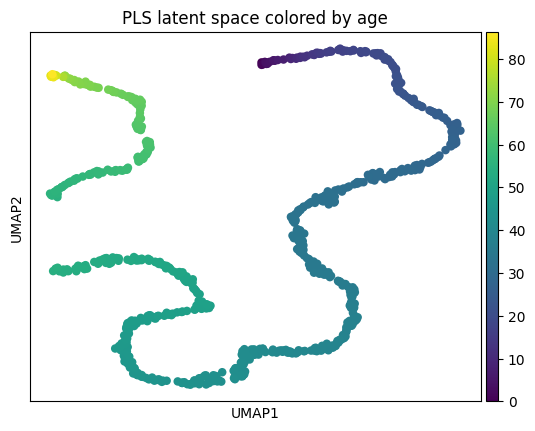

In [ ]:
adata.obsm["X_neural_pls"] = t_final.numpy()

sc.pp.neighbors(adata, use_rep="X_neural_pls")
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color="age",
    cmap="viridis",
    title="PLS latent space colored by age"
)